# Classification
Practical of the course "Introduction to Machine Learning in Geophysics" held dy Dr. Francesco Grigoli within the MSc in Exploration and Applied Geophysics at the University of Pisa, Italy. This is a practical on the two-class classification problem.
Within this practical you will:
- Generate synthetic training and test datasets
- Apply different classification models to the data and evalute their performance
- Use the scikit-learn library for simple two-class classification problems

## Loading required libraries
We will use numpy and matplotlib for data generation, manipulation and visualization.
Scikit-learn is the library we will use to solve our regression problem
conda install -c conda-forge tensorflow-datasets
conda install -c conda-forge tensorflow-hub
pip install tensorflow-addons

In [55]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_addons as tfa

# load the whole dataset, for data info
all_ds   = tfds.load("eurosat", with_info=True)
# load training, testing & validation sets, splitting by 60%, 20% and 20% respectively
#split0, split1, split2 = tfds.even_splits('train', n=3)
#train_ds = tfds.load("eurosat", split=split2, shuffle_files=False)

#split1=tfds.Split.TRAIN.subsplit(tfds.percent[:60])
#split2=tfds.Split.TRAIN.subsplit(tfds.percent[60:80])
#split3=tfds.Split.TRAIN.subsplit(tfds.percent[80:])

training = tfds.load("eurosat", split="train[:60%]")
validation = tfds.load("eurosat", split="train[60%:80%]")
test = tfds.load("eurosat", split="train[80%:]")



# (training, validation, test) = tfds.load("eurosat", split=[training, validation, test])
print(training)

#for tr in training:
    #print(tr['label'])

<PrefetchDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [56]:
# the class names
class_names = all_ds[1].features["label"].names
# total number of classes (10)
num_classes = len(class_names)
num_examples = all_ds[1].splits["train"].num_examples

Text(0.5, 1.0, 'Bar Plot showing Number of Samples on Each Class')

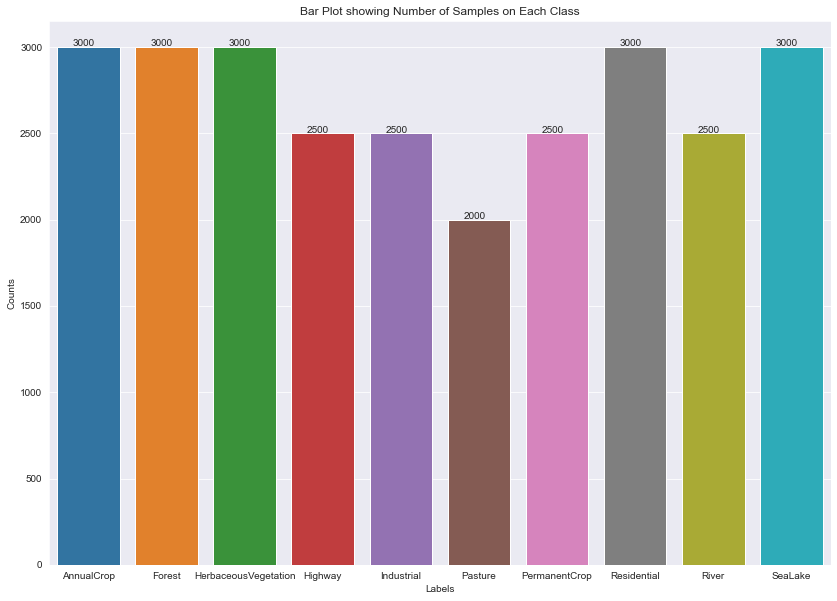

In [57]:
# make a plot for number of samples on each class
fig, ax = plt.subplots(1, 1, figsize=(14,10))
labels, counts = np.unique(np.fromiter(all_ds[0]["train"].map(lambda x: x["label"]), np.int32), 
                       return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Labels')
sns.barplot(x = [class_names[l] for l in labels], y = counts, ax=ax) 
for i, x_ in enumerate(labels):
  ax.text(x_-0.2, counts[i]+5, counts[i])
# set the title
ax.set_title("Bar Plot showing Number of Samples on Each Class")
# save the image
# plt.savefig("class_samples.png")

In [58]:
def prepare_for_training(ds, cache=False, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_classes)))
  #ds = ds.map(lambda d: (d["sentinel2"], tf.one_hot(d["label"], num_classes)))
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

In [59]:
batch_size = 64

# preprocess training & validation sets
training = prepare_for_training(training, batch_size=batch_size)
validation = prepare_for_training(validation, batch_size=batch_size)

In [60]:
# take the first batch of the training set
batch = next(iter(training))
batch

(<tf.Tensor: shape=(64, 64, 64, 3), dtype=uint8, numpy=
 array([[[[ 94, 127, 110],
          [ 94, 127, 110],
          [ 95, 128, 111],
          ...,
          [ 75, 123, 101],
          [ 73, 123,  98],
          [ 74, 124,  99]],
 
         [[ 94, 127, 110],
          [ 94, 127, 110],
          [ 94, 127, 110],
          ...,
          [ 75, 123, 101],
          [ 72, 121,  99],
          [ 74, 124,  99]],
 
         [[ 93, 128, 108],
          [ 93, 127, 110],
          [ 95, 127, 112],
          ...,
          [ 74, 123, 101],
          [ 75, 124, 102],
          [ 71, 120,  98]],
 
         ...,
 
         [[ 70, 122,  99],
          [ 70, 122, 100],
          [ 69, 121,  99],
          ...,
          [ 68, 120,  98],
          [ 68, 120,  97],
          [ 70, 122,  99]],
 
         [[ 70, 124, 101],
          [ 71, 125, 102],
          [ 70, 124, 101],
          ...,
          [ 67, 121,  97],
          [ 68, 120,  97],
          [ 67, 119,  96]],
 
         [[ 70, 124, 101],
 

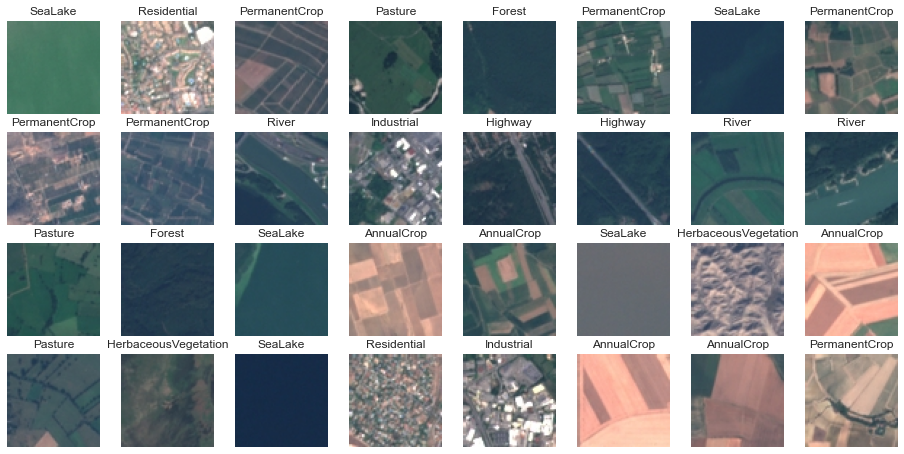

In [61]:
def show_batch(batch):
  plt.figure(figsize=(16, 16))
  for n in range(min(32, batch_size)):
      ax = plt.subplot(batch_size//8, 8, n + 1)
      # show the image
      plt.imshow(batch[0][n])
      # and put the corresponding label as title upper to the image
      plt.title(class_names[tf.argmax(batch[1][n].numpy())])
      plt.axis('off')
      plt.savefig("sample-images.png")

# showing a batch of images along with labels
#print(batch[0])
show_batch(batch)

In [76]:
from tensorflow import keras
# set the training & validation steps since we're using .repeat() on our dataset
# number of training steps
n_training_steps   = int(num_examples * 0.6) // batch_size
# number of validation steps
n_validation_steps = int(num_examples * 0.2) // batch_size

model = keras.models.Sequential()

model.build([None,64,64,3])

model.add(keras.layers.Flatten(input_shape=[64,64,3]))  # variables
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(5000, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2500, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(500, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


train_hist=model.fit(training, validation_data=validation, steps_per_epoch=n_training_steps, validation_steps=n_validation_steps, epochs=10)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 12288)             0         
                                                                 
 batch_normalization_12 (Bat  (None, 12288)            49152     
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 5000)              61445000  
                                                                 
 batch_normalization_13 (Bat  (None, 5000)             20000     
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            (None, 2500)              12502500  
                                                                 
 batch_normalization_14 (Bat  (None, 2500)            

In [63]:
## convolutional network
from tensorflow import keras
# set the training & validation steps since we're using .repeat() on our dataset
# number of training steps
n_training_steps   = int(num_examples * 0.6) // batch_size
# number of validation steps
n_validation_steps = int(num_examples * 0.2) // batch_size

model = keras.models.Sequential()

model.build([None,64,64,3])

model.add(keras.layers.Conv2D(6, 5, activation='tanh', input_shape=[64,64,3]))
model.add(keras.layers.AveragePooling2D(2))
model.add(keras.layers.Activation('sigmoid'))
model.add(keras.layers.Conv2D(16, 5, activation='tanh'))
model.add(keras.layers.AveragePooling2D(2))
model.add(keras.layers.Activation('sigmoid'))
model.add(keras.layers.Conv2D(120, 5, activation='tanh'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(84, activation='tanh'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


train_hist=model.fit(training, validation_data=validation, steps_per_epoch=n_training_steps, validation_steps=n_validation_steps, epochs=10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 30, 30, 6)        0         
 ooling2D)                                                       
                                                                 
 activation (Activation)     (None, 30, 30, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 13, 13, 16)       0         
 ePooling2D)                                                     
                                                                 
 activation_1 (Activation)   (None, 13, 13, 16)       

In [88]:
#####


model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2"

# download & load the layer as a feature vector
keras_layer = hub.KerasLayer(model_url, output_shape=[1280], trainable=True)

In [77]:
model = tf.keras.Sequential([
  keras_layer,
  tf.keras.layers.Dense(num_classes, activation="softmax")
])
# build the model with input image shape as (64, 64, 3)
model.build([None, 64, 64, 3])
model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy", tfa.metrics.F1Score(num_classes)]
)

NameError: name 'keras_layer' is not defined

In [8]:
model_name = "satellite-classification"
model_path = os.path.join("results", model_name + ".h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)

In [9]:
# set the training & validation steps since we're using .repeat() on our dataset
# number of training steps
n_training_steps   = int(num_examples * 0.6) // batch_size
# number of validation steps
n_validation_steps = int(num_examples * 0.2) // batch_size

In [29]:
# train the model
history = m.fit(
    training, validation_data=validation,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    verbose=1, epochs=2, 
    callbacks=[model_checkpoint]
)

Epoch 1/5
 90/253 [=========>....................] - ETA: 32:22 - loss: 0.8746 - accuracy: 0.7238 - f1_score: 0.7126

KeyboardInterrupt: 

In [20]:
# load the best weights
from tensorflow import keras
model_path='/Users/francesco/UniPi/Corsi/Summer_School_ML/Day4_practical/'
#model = keras.models.load_model(model_path+'satellite-classification.h5')
model = keras.models.load_model(model_path+'satellite-classification.h5',custom_objects={'KerasLayer':hub.KerasLayer})
#model.load_weights(model_path+'satellite-classification.h5')

#####

In [78]:
# number of testing steps
n_testing_steps = int(all_ds[1].splits["train"].num_examples * 0.2)

# get all testing images as NumPy array
images = np.array([ d["image"] for d in test.take(n_testing_steps) ])
print("images.shape:", images.shape)

# get all testing labels as NumPy array
labels = np.array([ d["label"] for d in test.take(n_testing_steps) ])
print("labels.shape:", labels.shape)

# feed the images to get predictions
predictions = model.predict(images)
# perform argmax to get class index
predictions = np.argmax(predictions, axis=1)
print("predictions.shape:", predictions.shape)

images.shape: (5400, 64, 64, 3)
labels.shape: (5400,)
169/169 [==============================] - 6s 34ms/step
predictions.shape: (5400,)


In [79]:
from sklearn.metrics import f1_score

accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(labels, predictions)
print("Accuracy:", accuracy.result().numpy())
print("F1 Score:", f1_score(labels, predictions, average="macro"))

Accuracy: 0.6287037
F1 Score: 0.6284286503337785


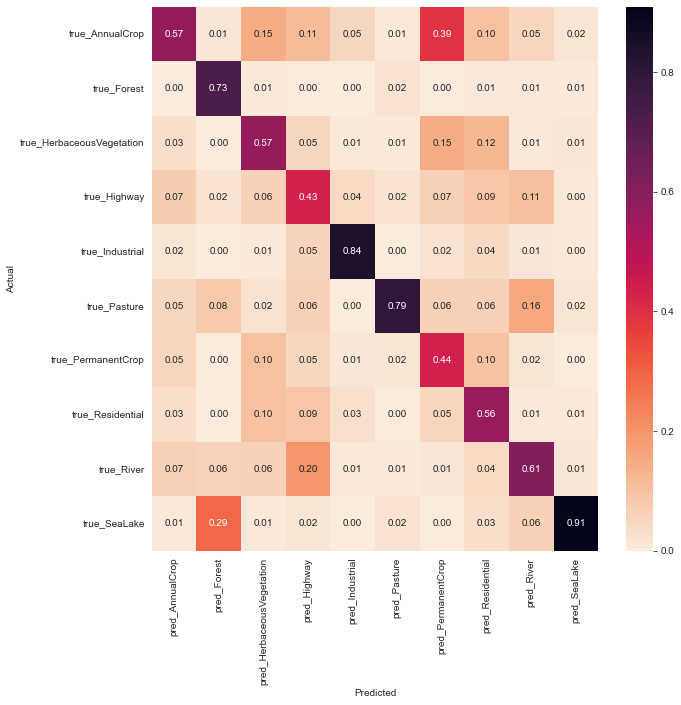

In [80]:
# compute the confusion matrix
cmn = tf.math.confusion_matrix(labels, predictions).numpy()
# normalize the matrix to be in percentages
cmn = cmn.astype('float') / cmn.sum(axis=0)[:, np.newaxis]
# make a plot for the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', 
            xticklabels=[f"pred_{c}" for c in class_names], 
            yticklabels=[f"true_{c}" for c in class_names],
            # cmap="Blues"
            cmap="rocket_r"
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plot the resulting confusion matrix
plt.savefig("confusion-matrix.png")
# plt.show()

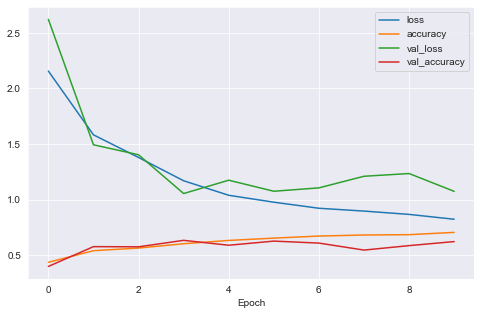

In [81]:
import pandas as pd
pd.DataFrame(train_hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('Epoch')
plt.show()

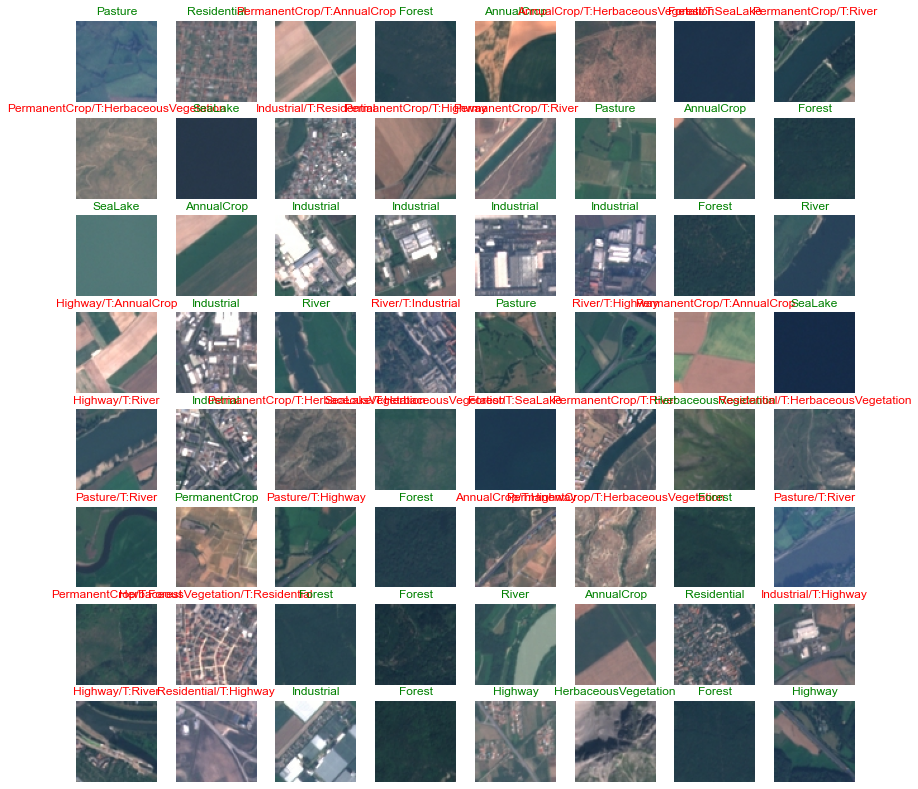

In [72]:
def show_predicted_samples():
  plt.figure(figsize=(14, 14))
  for n in range(64):
      ax = plt.subplot(8, 8, n + 1)
      # show the image
      plt.imshow(images[n])
      # and put the corresponding label as title upper to the image
      if predictions[n] == labels[n]:
        # correct prediction
        ax.set_title(class_names[predictions[n]], color="green")
      else:
        # wrong prediction
        ax.set_title(f"{class_names[predictions[n]]}/T:{class_names[labels[n]]}", color="red")
      plt.axis('off')
      plt.savefig("predicted-sample-images.png")

# showing a batch of images along with predictions labels
show_predicted_samples()

## Data Generation
We first define a set of utility function that will help us in generating the data